# Analyzing the effect of Goal Involvements on Market Value of Soccer Players

Group Members: Aryaman Rishabh (ar8643), Siddharth Bhardwaj (snb8849), Rashmika Ranjan (rr4552)  
***

In [1]:
import numpy as np
import arviz as az
import pandas as pd
import seaborn as sns
import pymc as pm
import networkx as nx
import seaborn as sns
import pytensor.tensor as pt
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

rnd_seed = 42
np.random.seed(rnd_seed)
%matplotlib inline

# %config Inline.figure_format = 'retina'
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

In [2]:
sns.set_context("talk")
plt.style.use('dark_background')

In [3]:
def standardize(series):
    return (series - series.mean()) / series.std()

Every year, hundreds of soccer players are traded, transferred, or bought by teams worldwide, with their market values often serving as a reflection of their perceived performance and potential. A critical factor in determining a player's market value is their goal involvements (i.e., goals scored and assists provided), which directly contribute to their team's success. However, the relationship between goal involvements and market value might differ depending on the player's position on the field, such as forward, midfielder, or defender.  

In this project, we aim to estimate the effect of a soccer player's goal involvements on their market value while stratifying by position. By exploring this relationship, we hope to understand whether the impact of goal involvements on market value is uniform across positions or varies significantly depending on the role a player fulfills on the field.

## Description:
This dataset contains information about soccer players from top-tier leagues around the world recorded over a period of 2 seasons, 2021-2022 and 2022-2023. It is designed to help build a predictive model for estimating players' transfer values based on various features.  
To enhance model evaluation, certain statistics, including "goals", "assists", "yellow cards", "second yellow cards", "red cards", "goals conceded", and "clean sheets", were normalized to a per 90-minute basis. This transformation was achieved by dividing each statistic by the player's corresponding "per 90 value" (minutes played divided by 90).

The columns have the following meaning:  
* name: Name of the player
* age: Age of the player (in years)
* appearance: The number of times a player appear on field
* height: Height of the player (in centimeters)
* position: Position the player primarily plays (e.g., forward, midfielder, defender, goalkeeper)
* goals: Goals scored by the player, normalized per 90 minutes
* assists: Assists provided by the player, normalized per 90 minutes
* yellow cards: Yellow cards received, normalized per 90 minutes
* second yellow cards: Second yellow cards received, normalized per 90 minutes
* red cards: Red cards received, normalized per 90 minutes
* goals conceded: Goals conceded (for goalkeepers), normalized per 90 minutes
* clean sheets: Clean sheets achieved (for goalkeepers), normalized per 90 minutes
* days injured: Total number of days a player has sustained injuries
* games injured: Total number of games a player has sustained injuries
* awards: Total number of individual awards won by the player
* current value: Current transfer market value of the player (in millions of Euros)
* highest value: Highest valuated price in the past (in millions of Euros)

This dataset offers a rich source of information to analyze and understand the factors influencing players' transfer market values, including performance metrics, disciplinary records, and accolades.

Source:  
[Kaggle - Soccer Players Pransfer Fee Dataset](https://www.kaggle.com/datasets/khanghunhnguyntrng/football-players-transfer-fee-prediction-dataset)

## Causal Model

The dataset contains information about professional football players across various leagues worldwide. In this context, the relationships between variables in the DAG can be described as follows:

Players' goal involvements (G), which include goals and assists, are a key measure of their offensive contribution to the team. These contributions are hypothesized to directly influence a player's current market value (V) as players who are more involved in scoring or assisting goals are typically valued higher in the transfer market.

The position played (P) by a player significantly impacts both their role on the field and their valuation in the market. For example, forwards generally have higher goal involvement and are more valuable than defenders. Consequently, position played influences both goal involvements (G) and current market value (V) directly.

The Causal Model can be defined by this DAG:

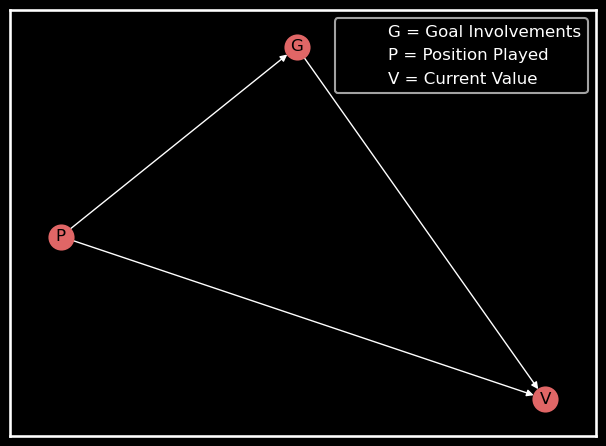

In [4]:
graph = nx.DiGraph()

# G = Goal Involvements
# P = Position Played
# V = Current Value

graph.add_edges_from([("G","V"), ("P","V"), ("P", "G")])

nx.draw_networkx(graph, arrows=True, node_color="#e06666", edge_color="#fff")
legend_elements = [
    Line2D([], [], color='black', lw=1, label='G = Goal Involvements'),
    Line2D([], [], color='black', lw=1, label='P = Position Played'),
    Line2D([], [], color='black', lw=1, label='V = Current Value')
]
plt.legend(handles=legend_elements, loc='best', fontsize=12)
plt.tight_layout()

where $G$ is `goalInvolvements`, $P$ is `positionPlayed`, and $V$ is `currentValue`.  

Goal involvements is our treatment variable, whose effect on the outcome variable, the Market Value, is what we aim to estimate. Position played is the confounding variable that influences both Goal Involvements and Market Value. It acts as a confounder because it creates a backdoor path between Goal Involvements and Market Value. To properly analyze the direct causal effect of Goal Involvements on Market Value, we will account for the effect of Position Played.  

We initially considered using a player's highest market value instead of their current market value as the treatment variable. The advantage of using the highest value is that it could reduce the confounding effect of age, as it reflects the player's peak value across seasons, regardless of their current age. However, since the goal involvements data we are analyzing is limited to the past two seasons, whereas the highest value may correspond to much older data, it could lead to a mismatch in timeframes.

## Data Pre-processing

We have followed a few steps to ensure the dataset is clean, consistent, and relevant for modeling. By filtering for top teams and valid data, we are focusing on players with reliable and significant performance indicators. Aggregating key metrics like goal involvements simplifies analysis, while normalizing values improves interpretability.

Filter for Top Teams:
Restrict the dataset to players from top_teams. Focus on players in more competitive environments where transfer values are more reliable indicators of performance.

Dropping Goalkeepers:  
Goalkeepers were removed from the dataset because their goal involvements - our key variable of interest - are almost always zero. Including them would have skewed the analysis and diluted insights about how offensive contributions impact market value.

Data cleaning:
Remove players with current_value <= 0. Exclude entries with missing, invalid, or irrelevant data (e.g., undefined positions or players with no market value).

Adjust Position Encoding:
Making position encoding 0-indexed.

Aggregate Goal Involvements:
Calculate goal_involvements as the sum of goals and assists. Create a single metric summarizing offensive contributions, relevant for assessing transfer value.

Normalize Current Value:
Scale current_value to millions. Simplify interpretation and reduce large numbers to a manageable scale.

Filter Low-Value Players:
Exclude players with current_value less than 0.05 million. Focus on players with significant market value to avoid noise from negligible or inaccurate estimates.

Standardize Goal Involvements:
Normalized data for better comparability and to align with modeling assumptions that may require standardized inputs.

Sample Subset for plotting:
Since there are over 10,000 rows in our dataset, select a random subset of 75 players for visualization.

In [5]:
top_teams = ['Manchester United', 'West Ham United', 'Leicester City',
       'Aston Villa', 'Wolverhampton Wanderers', 'Southampton FC',
       'Brighton &amp; Hove Albion', 'Everton FC', 'Nottingham Forest',
       'Leeds United', 'Crystal Palace', 'Fulham FC', 'AFC Bournemouth',
       'Brentford FC', 'Liverpool FC', 'Newcastle United',
       'Manchester City', 'Arsenal FC', 'Tottenham Hotspur', 'Chelsea FC',
       'Borussia Mönchengladbach', 'VfL Wolfsburg', 'TSG 1899 Hoffenheim',
       '1.FC Union Berlin', 'FC Augsburg', 'VfB Stuttgart',
       '1.FSV Mainz 05', '1.FC Köln', 'Hertha BSC', 'FC Schalke 04',
       'VfL Bochum', 'SV Werder Bremen', 'Eintracht Frankfurt',
       'SC Freiburg', 'Borussia Dortmund', 'Bayer 04 Leverkusen',
       'Bayern Munich', 'RB Leipzig', 'Real Sociedad', 'Villarreal CF',
       'Real Betis Balompié', 'Athletic Bilbao', 'Valencia CF',
       'Sevilla FC', 'Celta de Vigo', 'CA Osasuna', 'Girona FC',
       'Rayo Vallecano', 'RCD Mallorca', 'UD Almería',
       'Real Valladolid CF', 'Cádiz CF', 'Elche CF',
       'RCD Espanyol Barcelona', 'Getafe CF', 'Atlético de Madrid',
       'Real Madrid', 'FC Barcelona', 'AS Roma', 'SS Lazio',
       'ACF Fiorentina', 'US Sassuolo', 'Torino FC', 'Udinese Calcio',
       'Bologna FC 1909', 'AC Monza', 'FC Empoli', 'US Lecce',
       'Spezia Calcio', 'Hellas Verona', 'UC Sampdoria', 'US Cremonese',
       'US Salernitana 1919', 'Atalanta BC', 'SSC Napoli', 'Inter Milan',
       'AC Milan', 'Juventus FC', 'AS Monaco', 'Stade Rennais FC',
       'Olympique Marseille', 'OGC Nice', 'RC Lens', 'FC Nantes', 
        'AC Ajaccio', 'Olympique Lyon', 'LOSC Lille',
       'Stade Reims', 'RC Strasbourg Alsace', 'Paris Saint-Germain',
       'AZ Alkmaar', 'Twente Enschede FC', 'SL Benfica', 'Sporting CP', 
       'FC Utrecht', 'SC Heerenveen', 'Ajax Amsterdam', 'PSV Eindhoven',
       'Feyenoord Rotterdam', 'Besiktas JK', 'Burnley FC', 'FC Porto', 'Fenerbahce',
       'Galatasaray', 'Red Bull Salzburg', 'Santos FC', 'SC Braga', 'Sheffield United']

In [6]:
df = pd.read_csv("final_data.csv")
df = df[df.team.isin(top_teams)]
df = df[(df.position_encoded > 1) & (df.current_value > 0)]
df.position_encoded = df.position_encoded - 2
df["goals"] = df["goals"] * df["minutes played"] / 90
df["assists"] = df["assists"] * df["minutes played"] / 90
df["goal_involvements"] = df["goals"] + df["assists"]
df["current_value"] = df["current_value"] / 1000000
df = df[df['current_value'] >= 0.05]
df['goal_involvements_std'] = standardize(df['goal_involvements'])

df_sample = df.sample(75)
unique_positions = df.position_encoded.unique()
pos_label = ['defenders', 'midfielders', 'forwards']
# df[df.position_encoded == 2][df.goal_involvements == 0].loc[:, 'current_value'].mean()
# df.shape[0]
# df[df.position_encoded == 2].goal_involvements.mean()

In [7]:
current_value = df.current_value
goal_involvements = df.goal_involvements

## Prior Predictive Simulation

$\alpha$ ~ Normal(2, 0.5)  
$\beta$ ~ Normal(1, 0.5)  
$\sigma$ ~ Exponential(1)

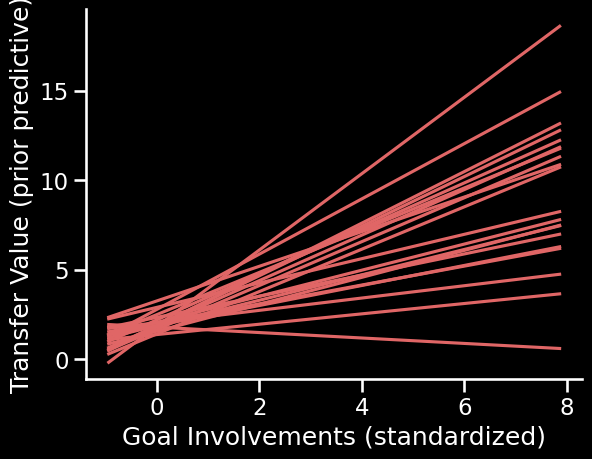

In [8]:
n = 20
a = stats.norm.rvs(2, 0.5, size=n)
b = stats.norm.rvs(1, 0.5, size=n)

involvements_seq = standardize(goal_involvements)
involvements_seq = np.linspace(involvements_seq.min(), involvements_seq.max(), 30)
for i in range(n):
    mu = a[i] + b[i] * involvements_seq
    plt.plot(involvements_seq, mu, color="#e06666")
    
plt.xlabel("Goal Involvements (standardized)")
plt.ylabel("Transfer Value (prior predictive)")
sns.despine();

The priors for a (intercept) and b (slope) were drawn from normal distributions, reflecting reasonable assumptions about the relationship between goal involvements and market value. The prior for a centers around 2 with a standard deviation of 0.5, representing our expected baseline value when goal involvements are standardized to zero. The prior for b, with a mean of 1 and a standard deviation of 0.5, captures the expected linear influence of goal involvements on market value. By simulating 20 samples and plotting the predicted trends, the priors demonstrate plausible variability and align with our general domain knowledge.

The use of normal distributions for the priors of a (intercept) and b (slope) is based on the assumption that these parameters follow continuous, symmetric distributions centered around reasonable estimates. Normal distributions are symmetric and flexible, which fits the assumption that the true values of a and b are likely to vary around their means, but are not heavily skewed or restricted to a particular direction.

Prior for a (Intercept):  
* The intercept represents the expected market value when goal involvements are zero (i.e., no goals or assists). A reasonable assumption is that players with no goal involvements still have some baseline value due to factors like experience, reputation, and other intrinsic qualities.   
* The prior for a is modeled as `Normal(2, 0.5)`, where the mean of 2 is based on a estimate of the baseline market value for players with minimal goal involvements. A value of 2 million is a reasonable starting point for an average player in top leagues, considering that player market values range from lower to very high values.   
* The standard deviation of 0.5 is chosen to reflect moderate uncertainty around this baseline. It suggests that while the baseline value may vary, it is unlikely to deviate substantially from the expected mean of 2 million.

Prior for b (Slope):  
* The slope b quantifies the relationship between goal involvements and market value. Given the nature of football, goal involvements (goals and assists) are often highly correlated with a player's market value, so we expect a positive relationship between b and the outcome.  
* The prior for b is modeled as `Normal(1, 0.5)`, where the mean of 1 reflects the assumption that goal involvements are expected to have a positive effect on market value, but the magnitude of this effect might vary across players. A value of 1 suggests that for each unit increase in goal involvements, the player's market value is expected to increase by a baseline value.  
* The standard deviation of 0.5 for b is chosen to reflect moderate uncertainty about the magnitude of this relationship. It allows for flexibility in the model while maintaining reasonable constraints, ensuring the slope is neither too large nor too small.

In [9]:
current_value_std = standardize(current_value)
goal_involvements_std = standardize(goal_involvements)

## Considering Goal Involvements as a Predictor

By taking goal involvements as our sole predictor this model estimates the total causal effect of goal involvements on the market value by ignoring the confounding variable (Position played).

$\mu$ = $\alpha$ + $\beta$ * *goal_involvements*

Market value is modeled using a normal distribution. This is done under the assumption that market values, when normalized or log-transformed, tend to follow a roughly symmetric distribution. The causal relationship assumes that goal involvements (G) influence market value (V) directly, as depicted in the DAG.

In [10]:
# validating m1 model
a = 2
b = 1
sigma = 1
n_players = 100
G = stats.uniform.rvs(0, 70, n_players)
mu = a + b * G
M = stats.norm.rvs(mu, sigma, n_players)
with pm.Model() as m1_sim:
    a = pm.Normal("a", mu=2, sigma=0.5)
    b = pm.Normal("b", mu=1, sigma=0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = a + b * G
    
    market_value = pm.Normal(
        "market_value", 
        mu=mu, 
        sigma=sigma, 
        observed=M
    )
    
    idata_m1_sim = pm.sample()

az.summary(idata_m1_sim, kind="stats", hdi_prob=0.89)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [a, b, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 8 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_5.5%,hdi_94.5%
a,2.035,0.178,1.729,2.302
b,0.997,0.004,0.991,1.005
sigma,0.982,0.070,0.871,1.093


The model validation process involves comparing the sampled parameter estimates to the true values we set for a and b while generating the data. The simulated data was generated using these known values, and we then used Bayesian inference to recover these parameters through sampling. This validation supports the robustness of the model, as the parameter estimates from the model reflect the true parameter values used to simulate the data, affirming the model's ability to accurately infer the underlying relationships in the data.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [a, b, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,3.312,0.300,2.873,3.830,0.008,0.005,1511.0,1679.0,1.0
b,0.595,0.019,0.565,0.625,0.000,0.000,1483.0,1620.0,1.0
sigma,13.984,0.198,13.675,14.296,0.005,0.004,1478.0,1168.0,1.0


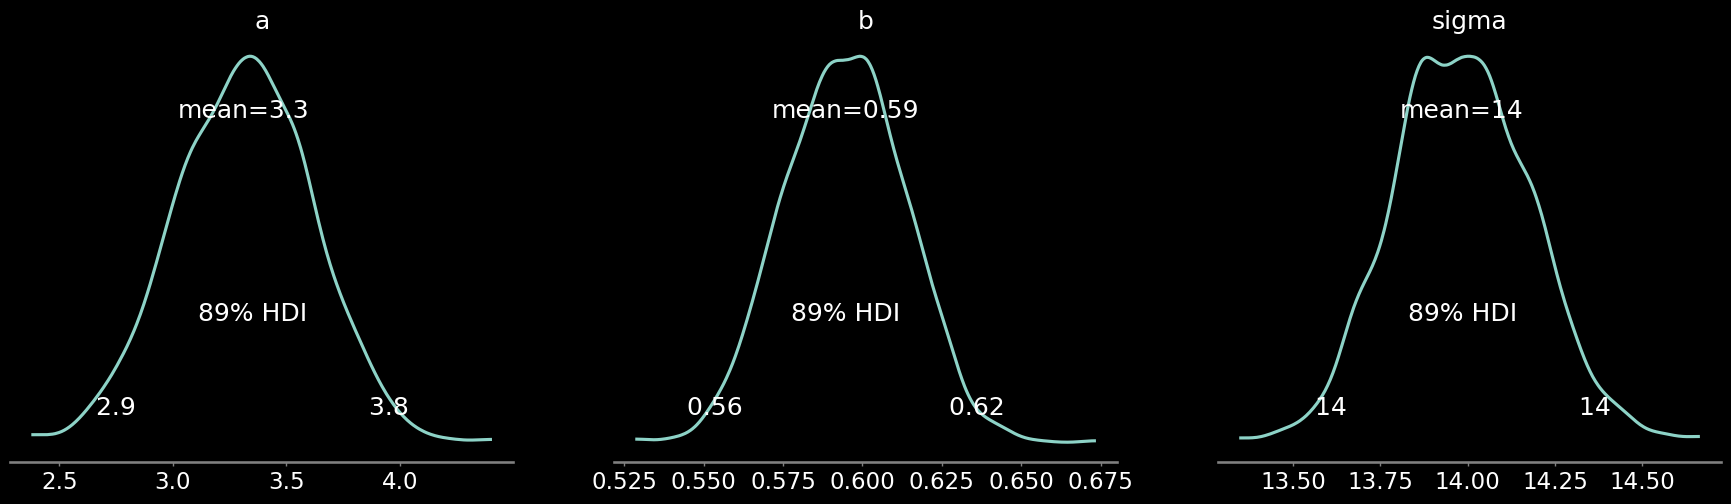

In [11]:
with pm.Model() as m1:
    a = pm.Normal("a", 2, 0.5)
    b = pm.Normal("b", 1, 0.5)
    mu = a + b * df.goal_involvements
    sigma = pm.Exponential("sigma", 1)

    market_value = pm.Normal("market_value", mu, sigma, observed = df.current_value)
    idata_m1 = pm.sample(idata_kwargs={"log_likelihood": True})

_ = az.plot_posterior(idata_m1)
az.summary(idata_m1, hdi_prob=0.89)

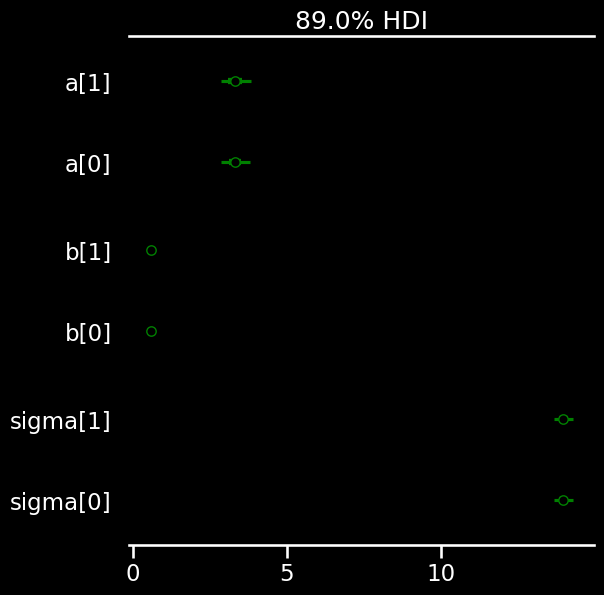

In [12]:
_ = az.plot_forest(idata_m1, colors='g')

* $\alpha$: estimated around 3.297  
    This is the intercept term, representing the baseline market value (on the standardized scale) when goal involvements are zero. The HDI (5.5% - 94.5%): [2.788, 3.755] interval suggests that the model is reasonably confident that the value of $\alpha$ lies within this range.
  
* $\beta$: estimated around 0.595
    This is the slope, indicating the expected increase in market value (on the standardized scale) for every one-unit increase in standardized goal involvements. The HDI (5.5% - 94.5%): [0.566, 0.625] interval suggests that the model is highly certain that the value of $\beta$ is positive, i.e., market value of a player increases with their goal involvements.

* $\sigma$: estimated around 13.989  
    This indicates the range of variability in the unexplained portion of the market value.


The `r_hat` values of 1.0 indicate no convergence issues, meaning the Markov chains are exploring the posterior distribution thoroughly, and the high `ess_bulk` values confirm that the effective sample size is large enough to provide precise estimates of the posterior parameters.

/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


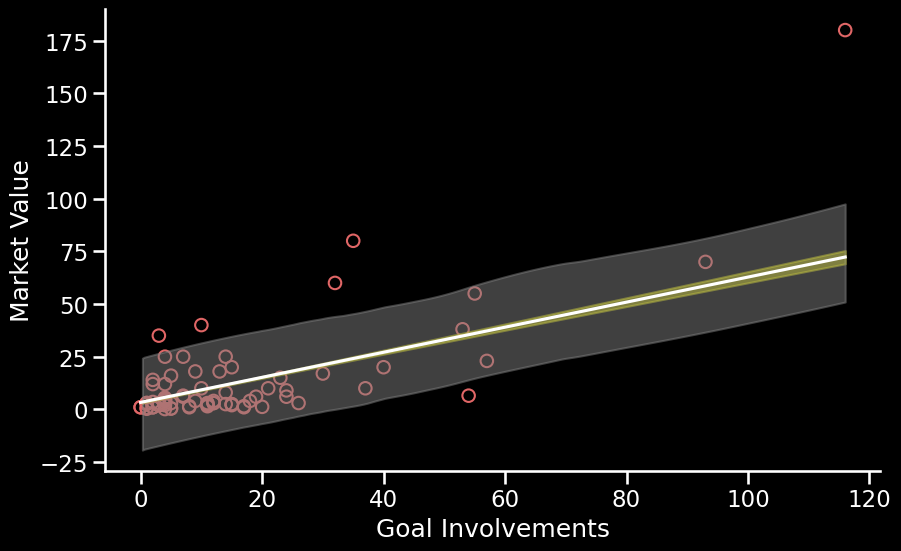

In [13]:
# m1 posterior predictive checks
plt.figure(figsize=(10, 6))

plt.scatter(df_sample.goal_involvements, df_sample.current_value, facecolors='none', edgecolors="#e06666")
plt.xlabel("Goal Involvements")
plt.ylabel("Market Value")
sns.despine()

goal_seq = np.linspace(df_sample.goal_involvements.min(), df_sample.goal_involvements.max(), 100)

idata_m1_thinned = az.extract(idata_m1, num_samples=1000)

a_values = idata_m1_thinned.a.values
b_values = idata_m1_thinned.b.values
sigma_values = idata_m1_thinned.sigma.values

mu_pred = np.zeros((len(goal_seq), idata_m1_thinned.sizes["sample"]))
for i, g in enumerate(goal_seq):
    mu_pred[i] = a_values + b_values * g

mu_mean = mu_pred.mean(axis=1)

plt.plot(goal_seq, mu_mean, color='w')

# uncertainty of posterior mean
az.plot_hdi(goal_seq, mu_pred.T, color="yellow")

market_value_pred = np.zeros((len(df_sample.goal_involvements), idata_m1_thinned.sizes["sample"]))
for i, g in enumerate(df_sample.goal_involvements):
    mu_pred_obs = a_values + b_values * g
    market_value_pred[i] = stats.norm.rvs(mu_pred_obs, sigma_values)

# uncertainty of predictions
az.plot_hdi(df_sample.goal_involvements, market_value_pred.T, color="gray")

plt.xlabel("Goal Involvements")
plt.ylabel("Market Value")
plt.show()

Based on the posterior and the plot generated we can conclude the following things:  
* The model captures the general positive association between goal involvements and market value.
* The model struggles to fit observed data points at both extremes,
    * **Low goal involvements, high market value:** Observed for defenders whose value isn't driven by scoring or creating goals.
    * **High goal involvements, moderate market value:** Likely outliers with limited overall contribution beyond scoring.
* A high standard deviation reflects that a significant portion of the variation in market value remains unexplained by this model, indicating the need for additional predictors, such as position, to better explain the variance in market value.

By not including position in the model, it assumes all players, regardless of their role (defenders, midfielders, and forwards), have an identical relationship between goal involvements and market value. This oversimplification ignores the nuances of player valuation. Excluding key variables such as position leads to under-fitting, as the model cannot fully capture the variation in market value driven by differences in roles and responsibilities on the field. The model assumes that goal involvements have the same impact across all positions. However, a defender with fewer goal involvements can still have a high market value due to exceptional defensive capabilities, which this model cannot capture.  

## Treating positions as independent categories

By stratifying the data by Position Played, this model estimates the direct causal effect of Goal Involvements on Market Value within each position group.

$\mu$ = $\alpha$[pos] + $\beta$[pos] * *goal_involvements*

This model introduces position as a categorical variable by assigning separate intercepts and slopes to each unique position. The parameters $\alpha$ (intercept) and $\beta$ (slope) are now modeled for each position individually. This allows the relationship between goal involvements and market value to vary by position.

In [14]:
# validating m2 model
n_players = 100
positions = np.random.choice([0, 1, 2], size=n_players)
goal_involvements = stats.uniform.rvs(0, 70, size=n_players)

a = np.array([1.5, 1, 2.5])
b = np.array([1, 0.8, 1.2])
sigma = 1

mu = a[positions] + b[positions] * goal_involvements
current_value = stats.norm.rvs(mu, sigma, n_players)

with pm.Model() as m2_sim:
    a = pm.Normal("a", mu=2, sigma=0.5, shape=len(np.unique(positions)))
    b = pm.Normal("b", mu=1, sigma=0.5, shape=len(np.unique(positions)))
    sigma = pm.Exponential("sigma", 1)
    mu = a[positions] + b[positions] * goal_involvements
    market_value = pm.Normal("market_value", mu=mu, sigma=sigma, observed=current_value)    
    idata_m2_sim = pm.sample()

az.summary(idata_m2_sim, kind="stats", hdi_prob=0.89)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [a, b, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_5.5%,hdi_94.5%
a[0],1.390,0.347,0.798,1.907
a[1],1.218,0.286,0.810,1.735
a[2],2.212,0.272,1.763,2.614
b[0],1.001,0.010,0.983,1.016
b[1],0.786,0.009,0.773,0.801
b[2],1.207,0.007,1.196,1.217
sigma,1.075,0.082,0.953,1.210


This validation assesses whether the stratified model correctly recovers the true parameter values for each positional group. Specifically, we generated data provided to the model using predefined values for a, b and sigma. This validation confirms that the model appropriately captures both positional stratification and the unique relationships within each group. The recovered parameters closely match their true values with their high density interval including the true value used, indicating the robustness of the model for analyzing stratified data.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [a, b, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 12 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],3.078,0.383,2.496,3.715,0.009,0.006,1990.0,1554.0,1.0
a[1],2.577,0.404,1.888,3.162,0.009,0.006,2161.0,1473.0,1.0
a[2],0.781,0.421,0.158,1.493,0.009,0.007,2054.0,1561.0,1.0
b[0],0.978,0.068,0.873,1.088,0.001,0.001,2138.0,1201.0,1.0
b[1],0.732,0.037,0.673,0.787,0.001,0.001,2315.0,1618.0,1.0
b[2],0.598,0.022,0.565,0.633,0.001,0.000,1798.0,1514.0,1.0
sigma,13.748,0.199,13.424,14.066,0.004,0.003,1985.0,1342.0,1.0


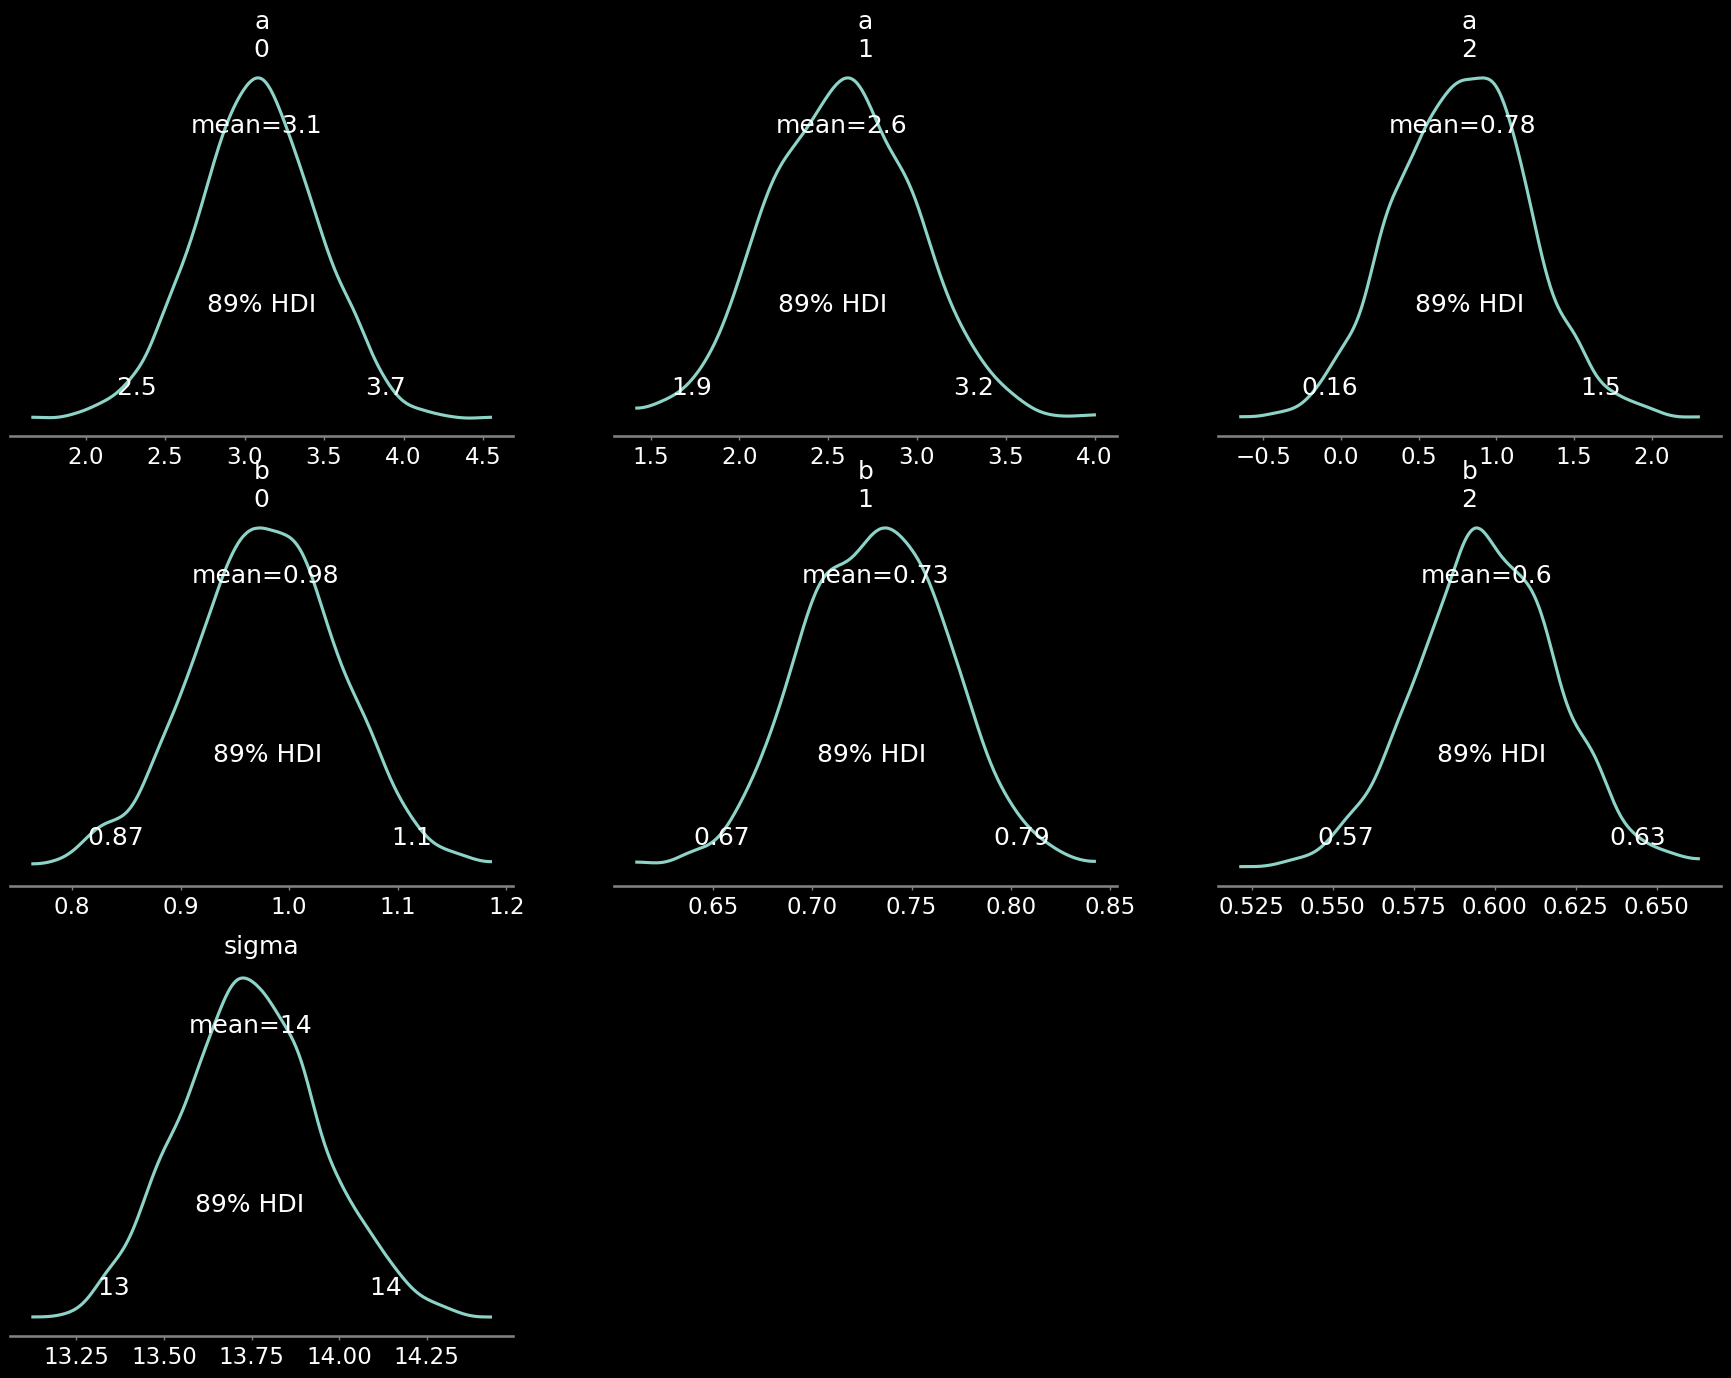

In [15]:
pos = df.position_encoded

with pm.Model() as m2:
    a = pm.Normal("a", mu=2, sigma=0.5, shape=len(pos.unique()))
    b = pm.Normal("b", mu=1, sigma=0.5, shape=len(pos.unique()))
    sigma = pm.Exponential("sigma", 1)
    mu = a[pos] + b[pos] * df.goal_involvements
    
    market_value = pm.Normal("market_value", mu, sigma, observed=df.current_value)
    
    idata_m2 = pm.sample(idata_kwargs={"log_likelihood": True})

_ = az.plot_posterior(idata_m2)
az.summary(idata_m2, hdi_prob=0.89)

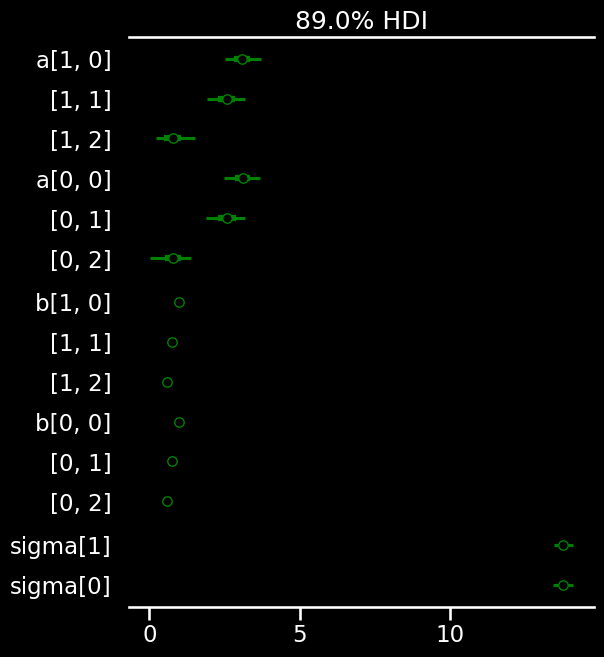

In [16]:
_ = az.plot_forest(idata_m2, colors='g')

* Defenders ($\alpha$[0], $\beta$[0])  
    Based on the intercept, the baseline market value for defenders with no goal involvements is approximately 3.07 million.  
    Each unit increase in standardized goal involvements is associated with a 0.98 million increase in market value.
  
* Midfielders ($\alpha$[1], $\beta$[1])  
    Based on the intercept, the baseline market value for midfielders with no goal involvements is approximately 2.57 million.  
    Each unit increase in standardized goal involvements is associated with a 0.73 million increase in market value.

* Forwards ($\alpha$[2], $\beta$[2])   
    Based on the intercept, the baseline market value for forwards with no goal involvements is approximately 0.78 million, the lowest among positions.
    Each unit increase in standardized goal involvements is associated with a 0.60 million increase in market value.

* $\sigma$: estimated around 13.741   
    Indicates considerable unexplained variability in the market value across all players, suggesting factors beyond position and goal involvements contribute to market value.


The baseline values ($\alpha$) suggest that defenders have the highest market value at zero goal involvements while forwards have thee lowest. This aligns with the understanding that a forward's market value is heavily driven by their goal contributions, as scoring goals is their primary role. Midfielders, in turn, have a moderately lower baseline value, reflecting their dual role in attack and defense. Defenders, however, are evaluated on a broader set of attributes beyond goal contributions, such as height (important for aerial duels), clean sheets (a key defensive metric), and goals conceded (indicating defensive effectiveness). These factors, although not included in the current model, play a significant role in determining their market value. Future iterations of this project could expand the model to incorporate such additional metrics, providing a more comprehensive analysis.

Similar to the previous model, the `r_hat` values of 1.0 confirms that the chains have properly converged, and the high `ess_bulk` values across all parameters suggest a good sampling efficiency.

/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/opt/conda/envs/fnds/lib/

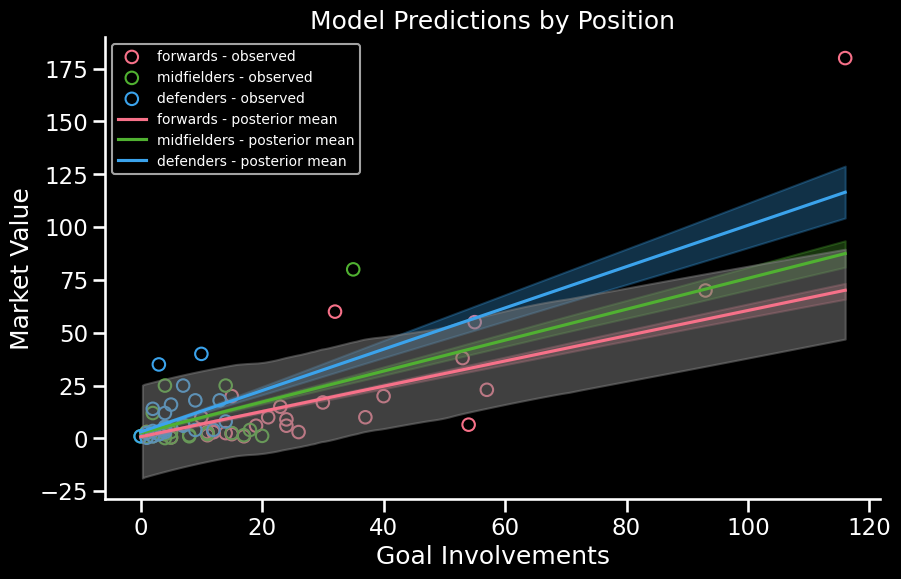

In [17]:
# m2 posterior predictive checks

palette = sns.color_palette("husl", len(df_sample.position_encoded.unique()))
plt.figure(figsize=(10, 6))
for i, pos in enumerate(df_sample.position_encoded.unique()):
    mask = df_sample.position_encoded == pos
    plt.scatter(
        df_sample.goal_involvements[mask], 
        df_sample.current_value[mask], 
        facecolors='none', 
        edgecolors=palette[i], 
        label=f"{pos_label[pos]} - observed"
    )

plt.xlabel("Goal Involvements")
plt.ylabel("Market Value")
sns.despine()

goal_seq = np.linspace(df_sample.goal_involvements.min(), df_sample.goal_involvements.max(), 100)
idata_m2_thinned = az.extract(idata_m2, num_samples=1000)
a_values = idata_m2_thinned.a.values
b_values = idata_m2_thinned.b.values
sigma_values = idata_m2_thinned.sigma.values

for i, pos in enumerate(df_sample.position_encoded.unique()):
    a_pos = a_values[pos]
    b_pos = b_values[pos]
    mu_pred = np.zeros((len(goal_seq), idata_m2_thinned.sizes["sample"]))
    for j, g in enumerate(goal_seq):
        mu_pred[j] = a_pos + b_pos * g

    mu_mean = mu_pred.mean(axis=1)
    plt.plot(goal_seq, mu_mean, color=palette[i], label=f"{pos_label[pos]} - posterior mean")
    az.plot_hdi(goal_seq, mu_pred.T, color=palette[i], hdi_prob=0.89, fill_kwargs={"alpha": 0.3})

market_value_pred = np.zeros((len(df_sample.goal_involvements), idata_m2_thinned.sizes["sample"]))
for i, g in enumerate(df_sample.goal_involvements):
    pos_index = df_sample.position_encoded.iloc[i]
    a_pos = a_values[pos_index]
    b_pos = b_values[pos_index]
    mu_pred_obs = a_pos + b_pos * g
    market_value_pred[i] = stats.norm.rvs(mu_pred_obs, sigma_values)

az.plot_hdi(df_sample.goal_involvements, market_value_pred.T, color="gray")

plt.legend(fontsize=10)
plt.xlabel("Goal Involvements")
plt.ylabel("Market Value")
plt.title("Model Predictions by Position")
plt.show()

### Discussion of Posterior Predictive Checks  

The posterior predictive checks for the model treating positions as independent categories align reasonably well with the observed data points for each position group, showing significant improvement in capturing position-specific dynamics compared to Model 1. This suggests that the model predictions based on positions is capturing the general distribution of goal involvements across the different positions.  

The observed data points for all positions generally fall within the credible intervals of the posterior predictions except for a few outliers, highlighting the importance of position stratification but signals the need for a more hierarchical approach to balance fit and generalization.

These insights highlight the model's strengths in capturing the position-specific patterns, while also pointing to potential areas for refinement.

By stratifying the parameters by position, the model assumes each position operates independently, disregarding any potential relationships or similarities between positions. For instance, midfielders and forwards often share responsibilities like contributing to goals, but this model cannot capture such overlap. The model also lacks "memory" or a shared structure across positions, meaning it cannot leverage patterns in the data that span multiple positions. For example, players transitioning between positions or exhibiting attributes shared across roles won't be modeled effectively. By considering separate parameters for each position, there is a risk of overfitting to the specific data of one position group, especially if the sample size for a particular position is small. This could result in unreliable estimates for rare or underrepresented positions. And By treating each position in isolation, the model loses the ability to generalize findings across positions. For example, market value trends driven by common factors like experience, age, or leadership qualities might not be captured.

## Multilevel/Hierarchical model

This model estimates the causal effect of Goal Involvements on Market Value while accounting for both position-specific and population-level effects. By incorporating Position Played hierarchically, it reduces bias from confounding and improves generalization through partial pooling. This approach allows for capturing the nuanced relationship between Goal Involvements and Market Value across positions while sharing information between groups to handle small sample sizes effectively.

$\mu$ = $\alpha_j$ + $\beta_j$ * *goal_involvements_std*

$\alpha_j$ ~ Normal($\bar\alpha$, $\sigma_a$)

$\beta_j$ ~ Normal($\bar\beta$, $\sigma_b$)

$\bar\alpha$ ~ Normal(2, 0.5)

$\bar\beta$ ~ Normal(1, 0.5)

$\sigma_a$ ~ Exponential(1)

$\sigma_b$ ~ Exponential(1)

This model considers position as a categorical variable by assigning separate intercepts ($\alpha_j$) and slopes ($\beta_j$) to each unique position. The parameters $\alpha_j$ (position-specific intercept) and $\beta_j$ (position-specific slope) are modeled hierarchically, allowing them to vary by position while being influenced by shared global distributions of $\bar\alpha$ and $\bar\beta$.

The intercepts and slopes are drawn from global normal distributions with means $\bar\alpha$ and $\bar\beta$ respectively. This structure captures both the variability across positions and the shared patterns in the data. The hyperparameters $\bar\alpha$ and $\bar\beta$ represent the overall baseline market value and the average effect of goal involvements across all positions. The standard deviations ($\alpha_{\sigma}$ and $\beta_{\sigma}$) quantify the extent of variation among positions.  
The model also includes a Exponential prior on $\sigma$, accounting for the unexplained variability in market value after considering position and goal involvements.

In [18]:
#validating m3

n_players = 100
n_positions = 3

positions = np.random.choice(np.arange(n_positions), size=n_players)
goal_involvements_std_seq = stats.uniform.rvs(0, 3, size=n_players)

true_a_bar = 2
true_a_sigma = 0.5
true_a = stats.norm.rvs(loc=true_a_bar, scale=true_a_sigma, size=n_positions)

true_b_bar = 0.5
true_b_sigma = 0.2
true_b = stats.norm.rvs(loc=true_b_bar, scale=true_b_sigma, size=n_positions)

true_sigma = 0.3

true_mu = true_a[positions] + true_b[positions] * goal_involvements_std_seq
log_market_value = stats.norm.rvs(loc=true_mu, scale=true_sigma, size=n_players)

with pm.Model() as m3_sim:
    a_bar = pm.Normal("a_bar", mu=2, sigma=0.5)
    a_sigma = pm.Exponential("a_sigma", 1)
    a = pm.Normal("a", mu=a_bar, sigma=a_sigma, shape=n_positions)
    
    b_bar = pm.Normal("b_bar", mu=1, sigma=0.5)
    b_sigma = pm.Exponential("b_sigma", 1)
    b = pm.Normal("b", mu=b_bar, sigma=b_sigma, shape=n_positions)
    
    sigma = pm.Exponential("sigma", 1)
    
    mu = a[positions] + b[positions] * goal_involvements_std_seq
    market_value = pm.Normal("market_value", mu=mu, sigma=sigma, observed=log_market_value)
    
    idata_m3_sim = pm.sample()

summary_m3_sim = az.summary(idata_m3_sim, hdi_prob=0.89)

print(summary_m3_sim)

print("True parameters vs Posterior means:")
print(f"a_bar: {true_a_bar:.2f} vs {summary_m3_sim.loc['a_bar', 'mean']:.2f}")
print(f"a_sigma: {true_a_sigma:.2f} vs {summary_m3_sim.loc['a_sigma', 'mean']:.2f}")
print(f"b_bar: {true_b_bar:.2f} vs {summary_m3_sim.loc['b_bar', 'mean']:.2f}")
print(f"b_sigma: {true_b_sigma:.2f} vs {summary_m3_sim.loc['b_sigma', 'mean']:.2f}")
print(f"sigma: {true_sigma:.2f} vs {summary_m3_sim.loc['sigma', 'mean']:.2f}")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [a_bar, a_sigma, a, b_bar, b_sigma, b, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 20 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


          mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
a_bar    2.128  0.358     1.583      2.709      0.009    0.006    1669.0   
a[0]     3.034  0.110     2.865      3.217      0.003    0.002    1955.0   
a[1]     1.601  0.109     1.433      1.779      0.003    0.002    1668.0   
a[2]     2.039  0.092     1.897      2.192      0.003    0.002    1367.0   
b_bar    0.493  0.259     0.126      0.868      0.008    0.007    1267.0   
b[0]     0.345  0.061     0.242      0.438      0.001    0.001    1894.0   
b[1]     0.140  0.066     0.029      0.238      0.002    0.001    1589.0   
b[2]     0.608  0.053     0.524      0.692      0.001    0.001    1404.0   
a_sigma  0.921  0.483     0.331      1.475      0.013    0.010    1616.0   
b_sigma  0.445  0.355     0.102      0.782      0.012    0.008     932.0   
sigma    0.305  0.024     0.270      0.345      0.001    0.000    2206.0   

         ess_tail  r_hat  
a_bar      1205.0   1.00  
a[0]       1335.0   1.00  
a[1]  

This validates the ability of the hierarchical model to recover both population-level and group-level parameters for a stratified dataset. The simulated data includes population-level means ($\bar\alpha$, $\bar\beta$) and standard deviations ($\sigma_a$, $\sigma_b$). The model effectively recovers both population-level and group-level parameters with the true value falling inside the high density interval of the estimated parameters. It demonstrates its ability to capture the hierarchical structure by balancing shared information (partial pooling) with group-specific details. The posterior estimates align closely with the true parameters, validating the model's robustness in modeling hierarchical relationships.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [a_bar, a_sigma, a, b_bar, b_sigma, b, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 18 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,1.776,0.256,1.363,2.145,0.007,0.005,1498.0,1075.0,1.0
a[0],2.078,0.065,1.978,2.184,0.002,0.001,1404.0,1349.0,1.0
a[1],1.647,0.042,1.583,1.716,0.001,0.001,2183.0,1686.0,1.0
a[2],1.362,0.054,1.277,1.448,0.001,0.001,1745.0,1409.0,1.0
b_bar,0.863,0.239,0.472,1.232,0.007,0.005,1460.0,1262.0,1.0
b[0],1.142,0.097,0.984,1.296,0.003,0.002,1459.0,1437.0,1.0
b[1],0.720,0.055,0.636,0.813,0.001,0.001,2553.0,1539.0,1.0
b[2],0.569,0.037,0.506,0.624,0.001,0.001,2042.0,1605.0,1.0
a_sigma,0.556,0.364,0.137,0.948,0.010,0.007,1771.0,1370.0,1.0
b_sigma,0.486,0.314,0.110,0.819,0.009,0.006,1605.0,1366.0,1.0


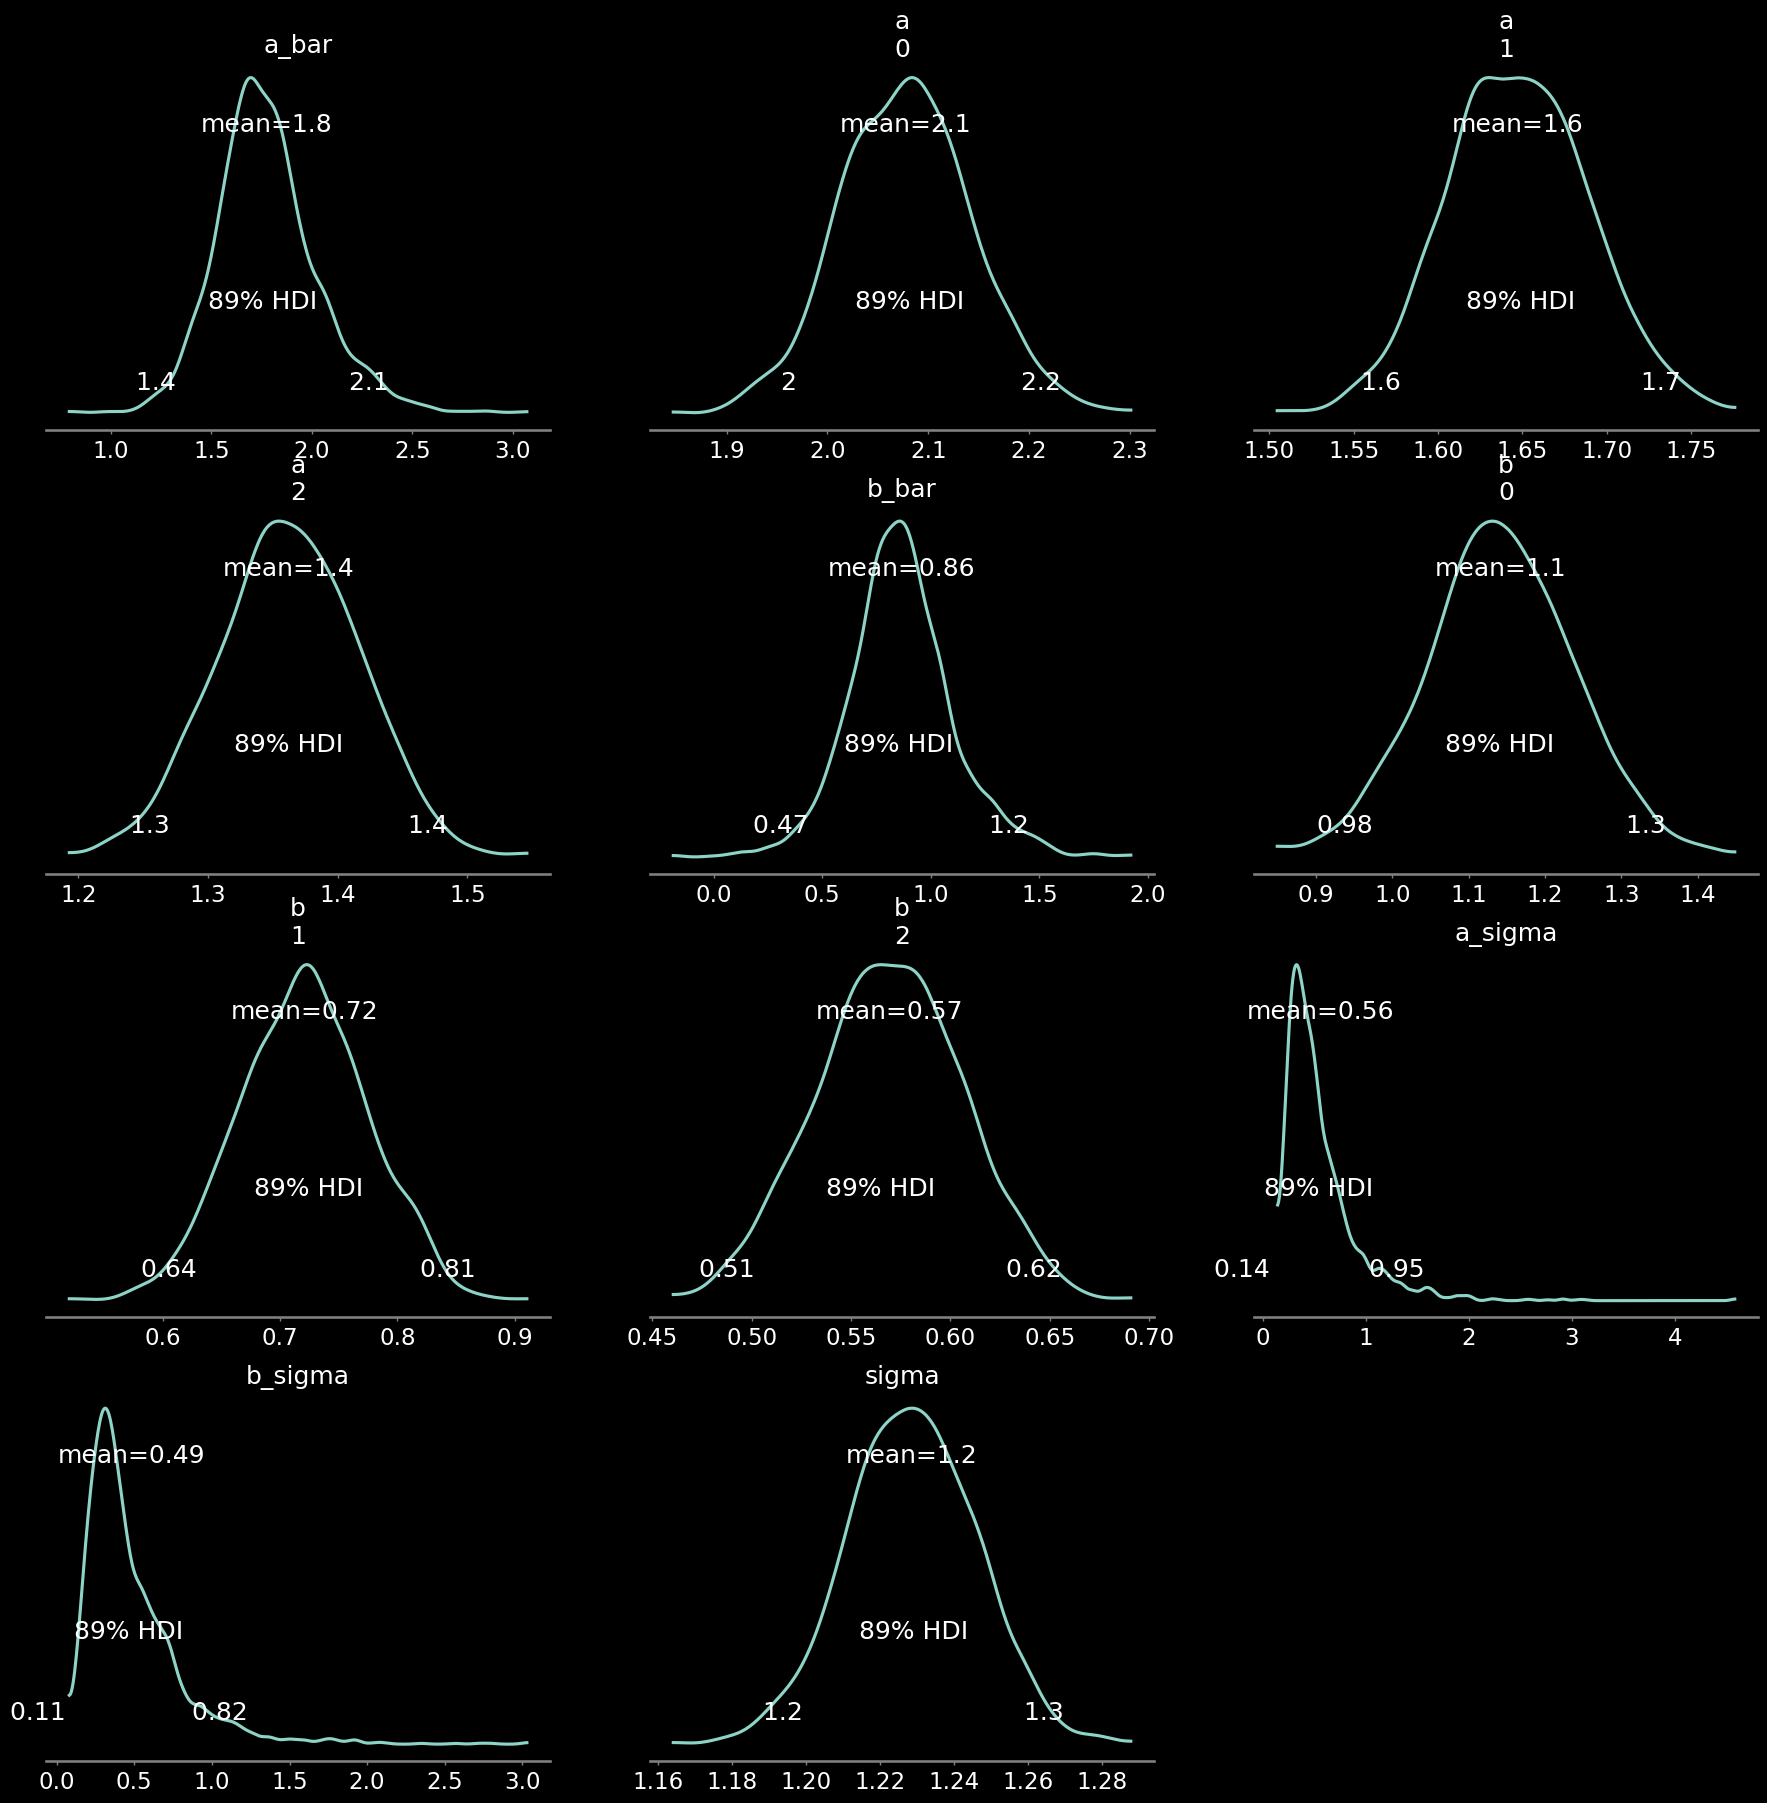

In [19]:
with pm.Model() as m3:
    a_bar = pm.Normal("a_bar", mu=2, sigma=0.5)
    a_sigma = pm.Exponential("a_sigma", 1)
    a = pm.Normal("a", 
                  mu=a_bar, 
                  sigma=a_sigma, 
                  shape=len(unique_positions))
    
    b_bar = pm.Normal("b_bar", mu=1, sigma=0.5)
    b_sigma = pm.Exponential("b_sigma", 1)
    b = pm.Normal("b", 
                  mu=b_bar, 
                  sigma=b_sigma, 
                  shape=len(unique_positions))
    
    sigma = pm.Exponential("sigma", 1)
    mu = a[df['position_encoded']] + b[df['position_encoded']] * df['goal_involvements_std']    
    market_value = pm.Normal("market_value", 
                             mu=mu, 
                             sigma=sigma, 
                             observed=np.log(df['current_value']))
    
    idata_m3 = pm.sample(idata_kwargs={"log_likelihood": True})

_ = az.plot_posterior(idata_m3)
az.summary(idata_m3, hdi_prob=0.89)

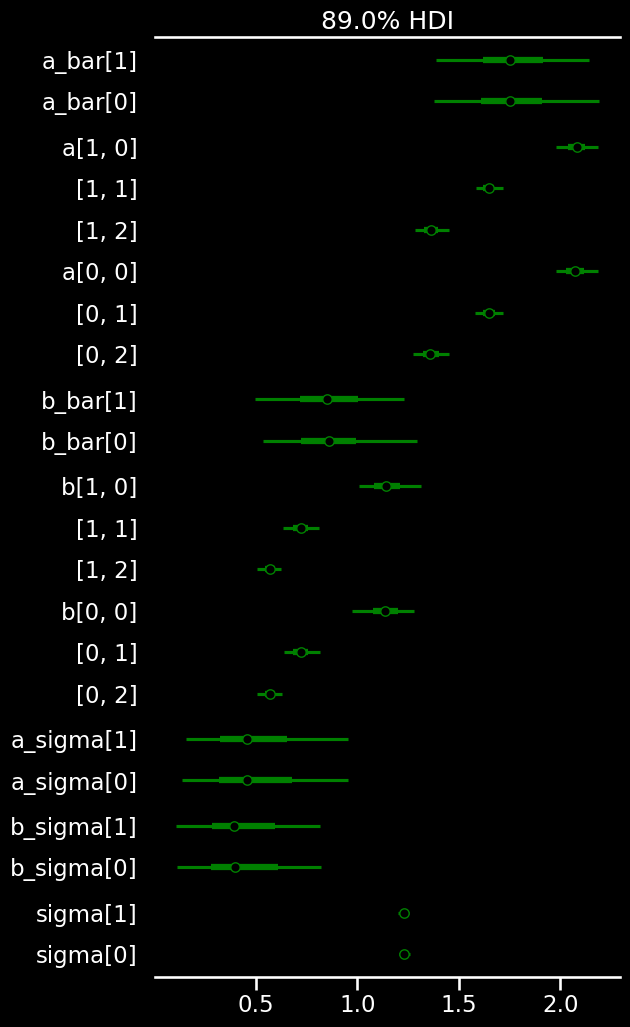

In [20]:
_ = az.plot_forest(idata_m3, colors='g')

Global Parameters:
* $\bar\alpha$ (Intercept Mean):
    Mean: 1.683, represents the overall baseline log-market value across all positions when goal involvements are standardized to 0. The standard deviation (0.313) indicates moderate uncertainty in the global intercept.

* $\bar\beta$ (Slope Mean):
    Mean: 0.728, represents the overall effect of goal involvements on log-market value across all positions.

* $\sigma_a$ and $\sigma_b$ (Position-Level Variability):
    $\sigma_a$: 0.565, suggests moderate variability in intercepts across positions.
    $\sigma_b$: 0.527, indicates moderate variability in slopes across positions.
    These capture the hierarchical structure, allowing positions to vary while being influenced by global trends.

Position-Specific Parameters:
* Defenders ($\alpha$[0], $\beta$[0])  
    $\alpha$[0]: 2.077 (highest intercept among positions), reflecting a higher baseline log-market value for defenders at 0 goal involvements.  
    $\beta$[0]: 1.139 (largest slope), showing a stronger influence of goal involvements on defenders' market value compared to other positions.
  
* Midfielders ($\alpha$[1], $\beta$[1])  
    $\alpha$[1]: 1.645, indicating a slightly lower baseline log-market value compared to defenders.  
    $\beta$[1]: 0.719, reflecting a moderate effect of goal involvements on midfielders' market value.

* Forwards ($\alpha$[2], $\beta$[2])   
    $\alpha$[2]: 1.361 (lowest intercept), showing a lower baseline log-market value for forwards at 0 goal involvements.  
    $\beta$[2]: 0.569 (smallest slope), suggesting a weaker impact of goal involvements on forwards' market value.

* $\sigma$: 1.228   
    Indicates the unexplained variability in log-market value not captured by the hierarchical model.  

The hierarchical model summary reveals position-specific differences in how goal involvements influence log-market value, while also capturing global trends. Defenders have the highest baseline market value (2.077) at 0 goal involvements, which aligns with expectations as their value is often influenced by attributes such as height, clean sheets, and goals conceded. Additionally, a defender with strong goal contributions alongside these skills sees a significant boost in their value, as reflected by the highest slope. Forwards, in contrast, have the lowest baseline market value (1.361), but their value relies more directly on goal involvements. While forwards typically see a gradual rise in value, exceptionally high goal contributions are required for a dramatic increase, as indicated by their smaller slope. Midfielders fall in between, with a baseline market value (1.645) lower than defenders but higher than forwards. Their slope suggests that goal involvements moderately influence their value, reflecting their dual role of contributing both defensively and offensively. This way the hierarchical approach effectively captures the unique dynamics of each position while incorporating global variability, offering a nuanced understanding of market value determinants.

/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/opt/conda/envs/fnds/lib/

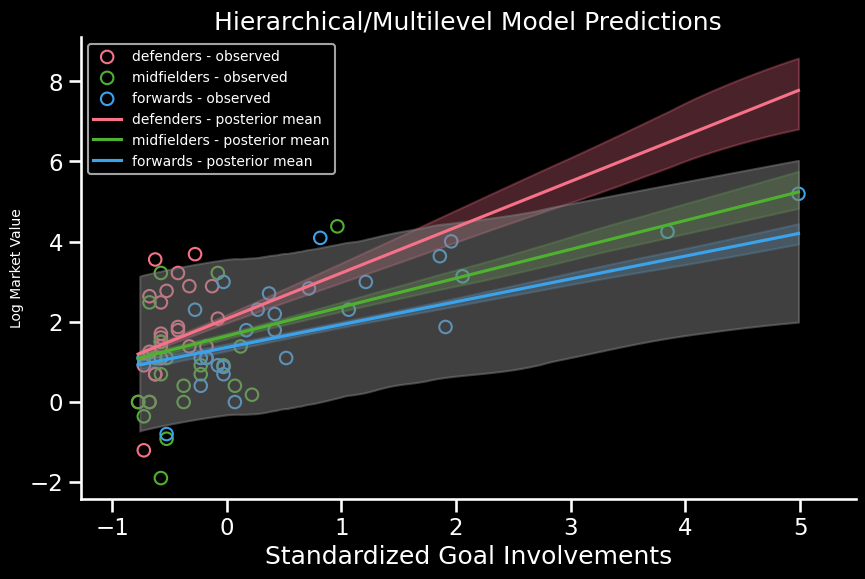

In [21]:
# m3 posterior predictive checks
goal_involvements_std_sample = standardize(df_sample.goal_involvements)

palette = sns.color_palette("husl", len(unique_positions))
plt.figure(figsize=(10, 6))
for i, pos in enumerate(unique_positions):
    mask = df_sample.position_encoded == pos
    plt.scatter(
        goal_involvements_std_sample[mask], 
        np.log(df_sample.current_value)[mask], 
        facecolors='none', 
        edgecolors=palette[i], 
        label=f"{pos_label[pos]} - observed"
    )

plt.xlabel("Standardized Goal Involvements")
plt.ylabel("Log Market Value")
sns.despine()

goal_seq = np.linspace(goal_involvements_std_sample.min(), goal_involvements_std_sample.max(), 100)

idata_m3_thinned = az.extract(idata_m3, num_samples=1000)

a_bar = idata_m3_thinned.a_bar.values
b_bar = idata_m3_thinned.b_bar.values
a_values = idata_m3_thinned.a.values 
b_values = idata_m3_thinned.b.values 
sigma_values = idata_m3_thinned.sigma.values

for i, pos in enumerate(unique_positions):
    a_pos = a_values[pos]
    b_pos = b_values[pos]
    mu_pred = np.zeros((len(goal_seq), idata_m3_thinned.sizes["sample"]))
    for j, g in enumerate(goal_seq):
        mu_pred[j] = a_pos + b_pos * g

    mu_mean = mu_pred.mean(axis=1)
    
    plt.plot(goal_seq, mu_mean, color=palette[i], label=f"{pos_label[pos]} - posterior mean")
    az.plot_hdi(goal_seq, mu_pred.T, color=palette[i], hdi_prob=0.89, fill_kwargs={"alpha": 0.3})

log_market_value_pred = np.zeros((len(goal_involvements_std_sample), idata_m3_thinned.sizes["sample"]))
for i, g in enumerate(goal_involvements_std_sample):
    pos_index = df_sample.position_encoded.iloc[i]
    a_pos = a_values[pos_index]
    b_pos = b_values[pos_index]
    mu_pred_obs = a_pos + b_pos * g
    log_market_value_pred[i] = stats.norm.rvs(mu_pred_obs, sigma_values)

az.plot_hdi(goal_involvements_std_sample, log_market_value_pred.T, color="gray")

plt.legend(fontsize=10)
plt.xlabel("Standardized Goal Involvements")
plt.ylabel("Log Market Value", fontsize=10)
plt.xlim(goal_involvements_std_sample.min() - 0.5, goal_involvements_std_sample.max() + 0.5)
plt.title("Hierarchical/Multilevel Model Predictions")
plt.show()

### Discussion of Posterior Predictive Checks  

The posterior predictive checks for the hierarchical/multilevel model align reasonably well with the  observed data points for all positions generally fall within the credible intervals of the posterior predictions, suggesting that the model adequately captures the central tendencies and uncertainties of the data. Meanwhile, the differences in posterior means across positions indicate that the model appropriately differentiates between the positional effects, with defenders showing steeper slopes than midfielders and forwards. This highlights the model's capacity to account for positional differences in performance metrics. 

The hierarchical model offers several significant benefits by leveraging both position-specific and population-level parameters. By modeling positions independently while sharing population-level parameters, the model introduces a "memory" that connects positional groups. This helps reduce overfitting for smaller positional groups, such as defenders with limited data, and improves predictive performance by capturing the hierarchical nature of the positions rather than treating them as completely distinct categories.  

Another strength of this partial pooling approach is its ability to provide estimates for positions with insufficient or missing data. For instance, the impact of goal involvements for a position like attacking midfielders, even if underrepresented, can still be inferred from the overall population-level parameters and trends in related positions.  

While the hierarchical structure mitigates overfitting, it assumes that all positions share some degree of similarity, which might not always hold true. Since the effective sample sizes (`ess_bulk`) and convergence diagnostics (`r_hat`) do not indicate any issues, adjustments like non-centered parameterization are not required to improve sampling efficiency and convergence.

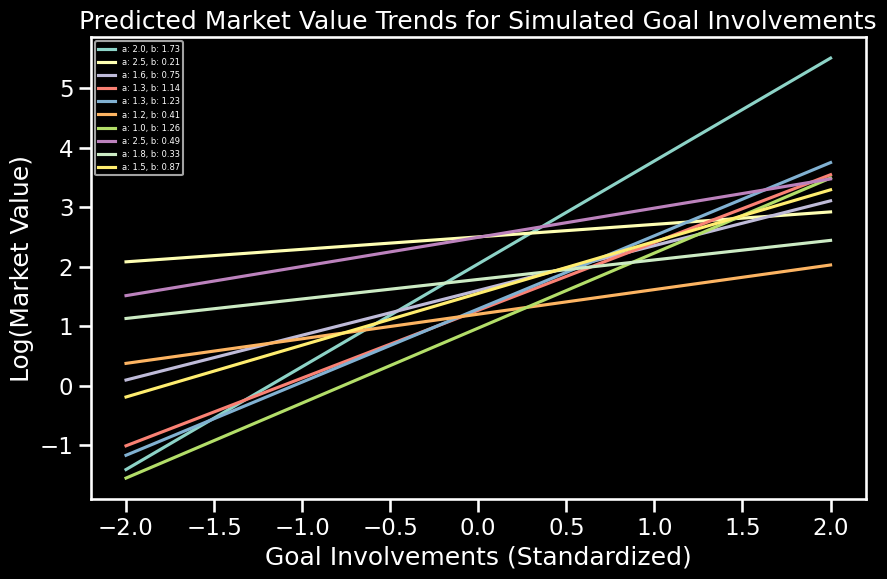

In [22]:
# Plotting simulated data from m3 parameters
mean_intercept = idata_m3.posterior["a_bar"].mean().item()
mean_slope = idata_m3.posterior["b_bar"].mean().item()

sa = idata_m3.posterior["a_sigma"].mean().item()
sb = idata_m3.posterior["b_sigma"].mean().item()

sigma = idata_m3.posterior["sigma"].mean().item()

simulated_goal_involvements = np.linspace(-2, 2, 100)

intercepts = stats.norm.rvs(mean_intercept, sa, size=10)
slopes = stats.norm.rvs(mean_slope, sb, size=10)

plt.figure(figsize=(10, 6))
for intercept, slope in zip(intercepts, slopes):
    market_values = intercept + slope * simulated_goal_involvements
    label = f"a: {intercept:.1f}, b: {slope:.2f}"
    plt.plot(simulated_goal_involvements, market_values, label=label)

plt.xlabel("Goal Involvements (Standardized)")
plt.ylabel("Log(Market Value)")
plt.title("Predicted Market Value Trends for Simulated Goal Involvements")
plt.legend(loc='upper left', fontsize=6)
plt.show()

## Considering correlation between parameters

This model introduces the correlation between the position-specific intercepts and slopes, allowing us to explicitly capture relationships between how positions affect baseline market value and the impact of goal involvements.

Correlations with LKJ Prior:  
The parameter `Rho_` is modeled using the LKJ prior, which is often used for correlation matrices. This ensures valid correlations between −1 and 1 while allowing flexibility.

Position-specific Parameters:  
Instead of treating intercepts and slopes for each position independently, they are now drawn from a multivariate normal distribution (ab_position) with shared population-level means ($\bar\alpha$, $\bar\beta$) and a covariance structure ($\sigma$). Sigma is constructed using the variances ($\sigma_a$, $\sigma_b$) and the correlation matrix `Rho`. This captures both the variability of intercepts/slopes within positions and their mutual relationship, if any.

In [23]:
with pm.Model() as m4:
    Rho_ = pm.LKJCorr("corr", n=2, eta=4)
    
    a_bar = pm.Normal("a_bar", mu=2, sigma=0.5)
    b_bar = pm.Normal("b_bar", mu=1, sigma=0.5)
    
    a_sigma = pm.Exponential("a_sigma", 1)
    b_sigma = pm.Exponential("b_sigma", 1)
    
    Rmat = pm.Deterministic("Rho", pt.stack([[1, Rho_[0]], [Rho_[0], 1]]))
    
    Sigma = pm.Deterministic("Sigma", pm.math.dot(
        pm.math.dot(pt.diag([a_sigma, b_sigma]), Rmat),
        pt.diag([a_sigma, b_sigma])
    ))
    
    ab_position = pm.MvNormal("ab_position", 
                               mu=pt.stack([a_bar, b_bar]), 
                               cov=Sigma, 
                               shape=(len(unique_positions), 2))
    
    a = pm.Deterministic("a", ab_position[:, 0])
    b = pm.Deterministic("b", ab_position[:, 1])
    
    sigma = pm.Exponential("sigma", 1)
    mu = a[df['position_encoded']] + b[df['position_encoded']] * df['goal_involvements_std']
    
    market_value = pm.Normal("market_value", 
                              mu=mu, 
                              sigma=sigma, 
                              observed=np.log(df['current_value']))
    idata_m4 = pm.sample(idata_kwargs={"log_likelihood": True})

az.summary(idata_m4, hdi_prob=0.89)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [corr, a_bar, b_bar, a_sigma, b_sigma, ab_position, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 106 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,1.778,0.271,1.375,2.195,0.007,0.005,1591.0,966.0,1.0
b_bar,0.861,0.246,0.479,1.243,0.007,0.006,1253.0,873.0,1.0
"ab_position[0, 0]",2.077,0.066,1.970,2.179,0.002,0.001,1223.0,1281.0,1.0
"ab_position[0, 1]",1.139,0.099,0.992,1.302,0.003,0.002,1121.0,1369.0,1.0
"ab_position[1, 0]",1.647,0.041,1.583,1.713,0.001,0.001,1492.0,1213.0,1.0
"ab_position[1, 1]",0.722,0.057,0.631,0.811,0.001,0.001,2529.0,1406.0,1.0
"ab_position[2, 0]",1.364,0.053,1.278,1.449,0.001,0.001,1587.0,1371.0,1.0
"ab_position[2, 1]",0.567,0.036,0.510,0.624,0.001,0.001,1615.0,1583.0,1.0
corr[0],0.162,0.318,-0.350,0.670,0.007,0.007,2027.0,1191.0,1.0
a_sigma,0.554,0.362,0.167,0.969,0.011,0.008,1279.0,1144.0,1.0


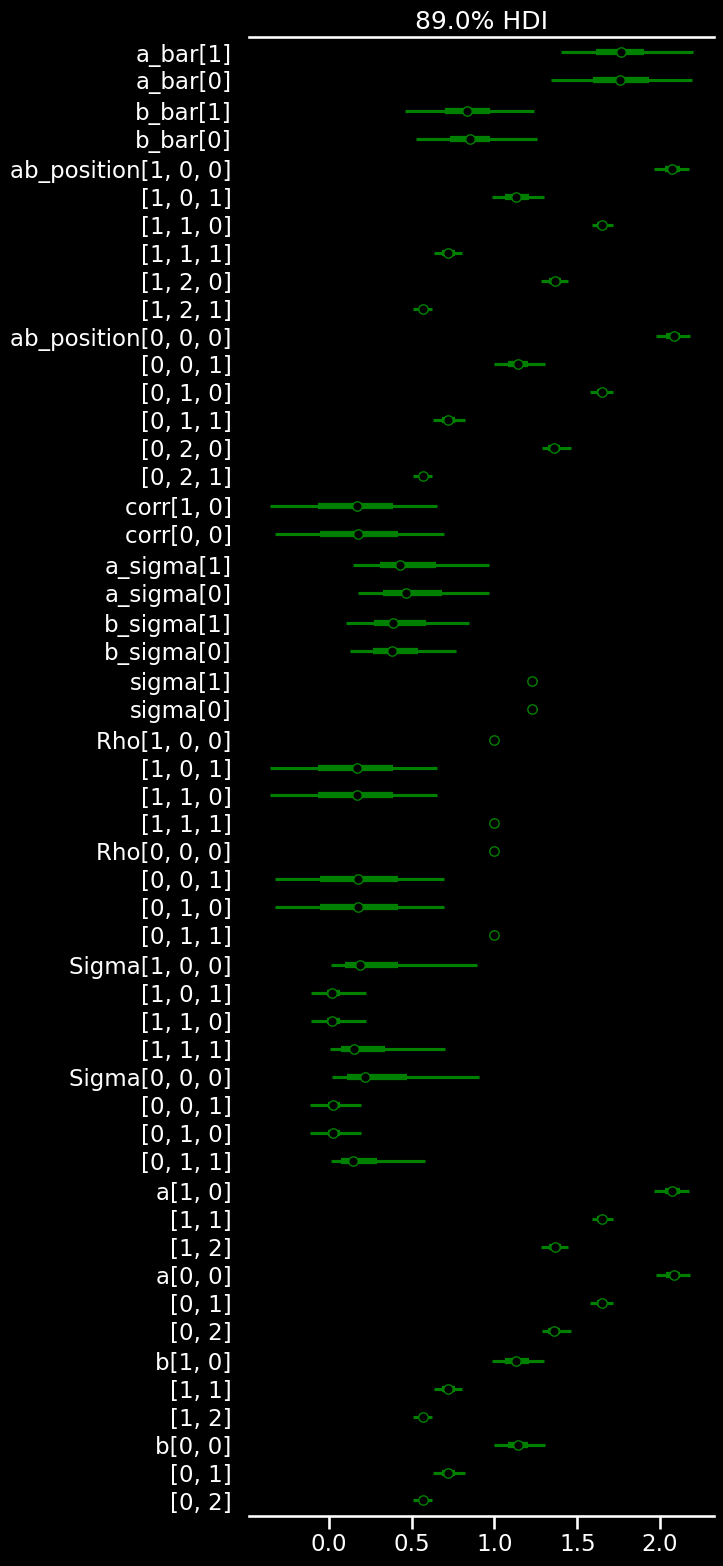

In [24]:
_ = az.plot_forest(idata_m4, colors='g')

This summary provides a breakdown of the model's parameters, including population-level values, position-specific intercepts (a) and slopes (b), and their correlations. The population-level means (a_bar and b_bar) indicate an overall baseline market value and average sensitivity to goal involvements, respectively. The position-specific parameters (ab_position) reveal how each position (defenders, midfielders, forwards) deviates from these population-level values. For example, defenders (a[0] and b[0]) have the highest baseline market value and relatively high sensitivity to goal involvements, as seen earlier.

The correlation between intercepts and slopes (corr) has a mean of 0.150 but with considerable uncertainty, as reflected by the wide HDI (-0.427 to 0.672), which also includes 0. This suggests only weak or no evidence of a consistent relationship between baseline market value and sensitivity to goal involvements across positions. The hierarchical structure allows partial pooling through population-level parameters (a_bar, b_bar, a_sigma, b_sigma), enabling the model to share information across positions while allowing position-specific flexibility.

/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/opt/conda/envs/fnds/lib/

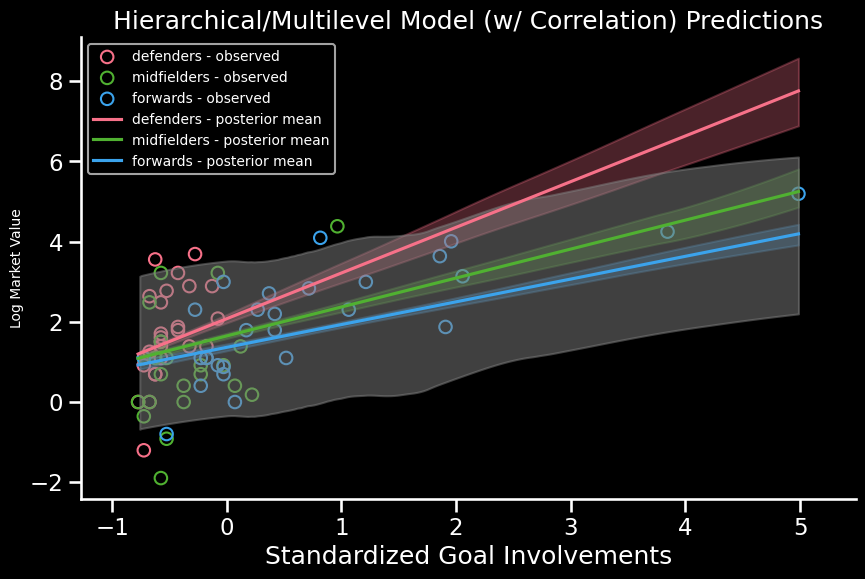

In [25]:
# m4 posterior predictive checks
goal_involvements_std_sample = standardize(df_sample.goal_involvements)

palette = sns.color_palette("husl", len(unique_positions))
plt.figure(figsize=(10, 6))
for i, pos in enumerate(unique_positions):
    mask = df_sample.position_encoded == pos
    plt.scatter(
        goal_involvements_std_sample[mask], 
        np.log(df_sample.current_value)[mask], 
        facecolors='none', 
        edgecolors=palette[i], 
        label=f"{pos_label[pos]} - observed"
    )

plt.xlabel("Standardized Goal Involvements")
plt.ylabel("Log Market Value")
sns.despine()

goal_seq = np.linspace(goal_involvements_std_sample.min(), goal_involvements_std_sample.max(), 100)

idata_m4_thinned = az.extract(idata_m4, num_samples=1000)

a_bar = idata_m4_thinned.a_bar.values  # Global intercept mean
b_bar = idata_m4_thinned.b_bar.values  # Global slope mean
a_values = idata_m4_thinned.a.values   # Position-specific intercepts
b_values = idata_m4_thinned.b.values   # Position-specific slopes
sigma_values = idata_m4_thinned.sigma.values

for i, pos in enumerate(unique_positions):
    a_pos = a_values[pos]
    b_pos = b_values[pos]
    mu_pred = np.zeros((len(goal_seq), idata_m4_thinned.sizes["sample"]))
    for j, g in enumerate(goal_seq):
        mu_pred[j] = a_pos + b_pos * g

    mu_mean = mu_pred.mean(axis=1)
    
    plt.plot(goal_seq, mu_mean, color=palette[i], label=f"{pos_label[pos]} - posterior mean")
    az.plot_hdi(goal_seq, mu_pred.T, color=palette[i], hdi_prob=0.89, fill_kwargs={"alpha": 0.3})

log_market_value_pred = np.zeros((len(goal_involvements_std_sample), idata_m4_thinned.sizes["sample"]))
for i, g in enumerate(goal_involvements_std_sample):
    pos_index = df_sample.position_encoded.iloc[i]
    a_pos = a_values[pos_index]
    b_pos = b_values[pos_index]
    mu_pred_obs = a_pos + b_pos * g
    log_market_value_pred[i] = stats.norm.rvs(mu_pred_obs, sigma_values)

az.plot_hdi(goal_involvements_std_sample, log_market_value_pred.T, color="gray")

plt.legend(fontsize=10)
plt.xlabel("Standardized Goal Involvements")
plt.ylabel("Log Market Value", fontsize=10)
plt.xlim(goal_involvements_std_sample.min() - 0.5, goal_involvements_std_sample.max() + 0.5)
plt.title("Hierarchical/Multilevel Model (w/ Correlation) Predictions")
plt.show()

### Discussion of Posterior Predictive Checks  

The posterior predictive checks for the hierarchical/multilevel model with correlations demonstrate how well the model captures the observed data patterns across positions (defenders, midfielders, and forwards). The model predictions, represented by the posterior mean for each position, align well with the observed data points, as evidenced by the overlap of the observed points with the respective position-specific prediction bands.

**Positional Analysis:**  
* **Defenders:** The larger uncertainty bands for the posterior mean defenders at higher goal involvements suggest higher variability in the data for this group. This is likely due to the smaller sample size of defenders with substantial goal involvements, which results in wider credible intervals. The model reasonably accounts for this uncertainty by reflecting it in the broader prediction band.  

* **Midfielders and Forwards:** The posterior mean uncertainty for midfielders and forwards are narrower compared to defenders, indicating that the model has higher confidence in its estimation of parameters for these positions at higher goal contributions. This is consistent with the greater amount of data available for players in these roles, particularly those with significant goal contributions.  

The observed data points for all positions generally fall within the credible intervals of the posterior predictions, suggesting that the model adequately captures the central tendencies and uncertainties of the data. The differences in posterior means across positions accurately reflects the positional variability and uncertainty, demonstrating the model's robustness in addressing the question and handling positional confounding.

This model also uses a hierarchical framework to capture shared information across player positions, allowing intercepts (baseline market value) and slopes (impact of goal involvements) to vary by position while being informed by population-level parameters. By incorporating correlations between intercepts and slopes, the model provides insights into how positions with higher baseline values may exhibit differing sensitivities to goal contributions.

However, the added complexity may demand greater computational resources and careful monitoring for convergence. Additionally, correlations may be prone to overinterpretation if insufficient data supports them, potentially overstating relationships between positional parameters.

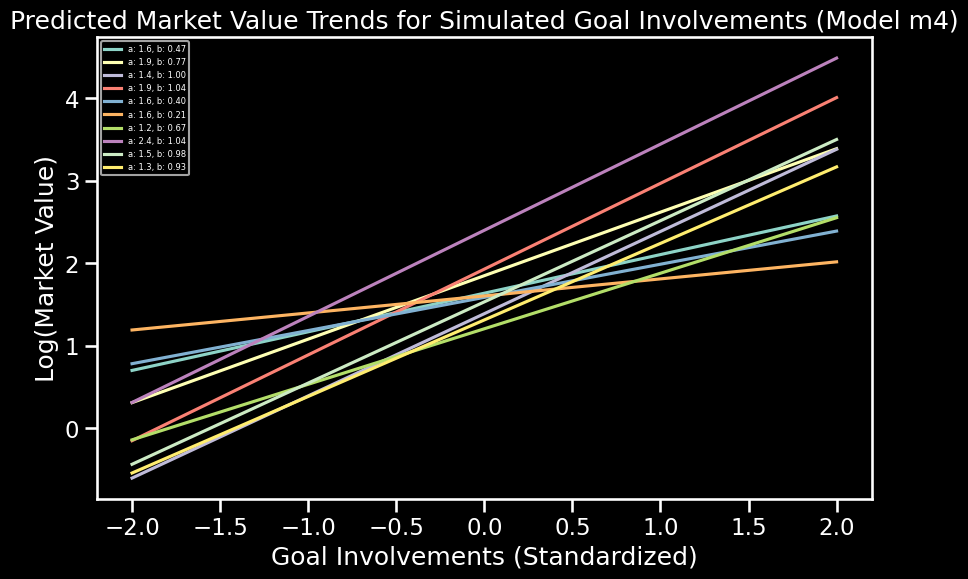

In [28]:
mean_a_bar = idata_m4.posterior["a_bar"].mean().item()
mean_b_bar = idata_m4.posterior["b_bar"].mean().item()
mean_a_sigma = idata_m4.posterior["a_sigma"].mean().item()
mean_b_sigma = idata_m4.posterior["b_sigma"].mean().item()

mean_rho = idata_m4.posterior["Rho"].sel(Rho_dim_0=0, Rho_dim_1=1).mean().item()

Sigma = np.array([
    [mean_a_sigma**2, mean_a_sigma * mean_b_sigma * mean_rho],
    [mean_a_sigma * mean_b_sigma * mean_rho, mean_b_sigma**2]
])

simulated_params = stats.multivariate_normal.rvs(
    mean=[mean_a_bar, mean_b_bar],
    cov=Sigma,
    size=10
)

simulated_goal_involvements = np.linspace(-2, 2, 100)

plt.figure(figsize=(10, 6))
for intercept, slope in simulated_params:
    market_values = intercept + slope * simulated_goal_involvements
    label = f"a: {intercept:.1f}, b: {slope:.2f}"
    plt.plot(simulated_goal_involvements, market_values, label=label)

plt.xlabel("Goal Involvements (Standardized)")
plt.ylabel("Log(Market Value)")
plt.title("Predicted Market Value Trends for Simulated Goal Involvements (Model m4)")
plt.legend(loc='upper left', fontsize=6)
plt.show()

                                                 rank      elpd_loo  \
m4 (correlated goal involvements with position)     0   8333.114126   
m3 (multilevel goal involvements with position)     1   8333.348691   
m2 (goal involvements with position)                2  20738.857623   
m1 (goal involvements only)                         3  20822.397961   

                                                     p_loo     elpd_diff  \
m4 (correlated goal involvements with position)   7.464917      0.000000   
m3 (multilevel goal involvements with position)   7.597043      0.234565   
m2 (goal involvements with position)             18.110267  12405.743497   
m1 (goal involvements only)                      12.075270  12489.283835   

                                                   weight          se  \
m4 (correlated goal involvements with position)  0.999993   78.330919   
m3 (multilevel goal involvements with position)  0.000007   78.250746   
m2 (goal involvements with position)        

/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'deviance' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["

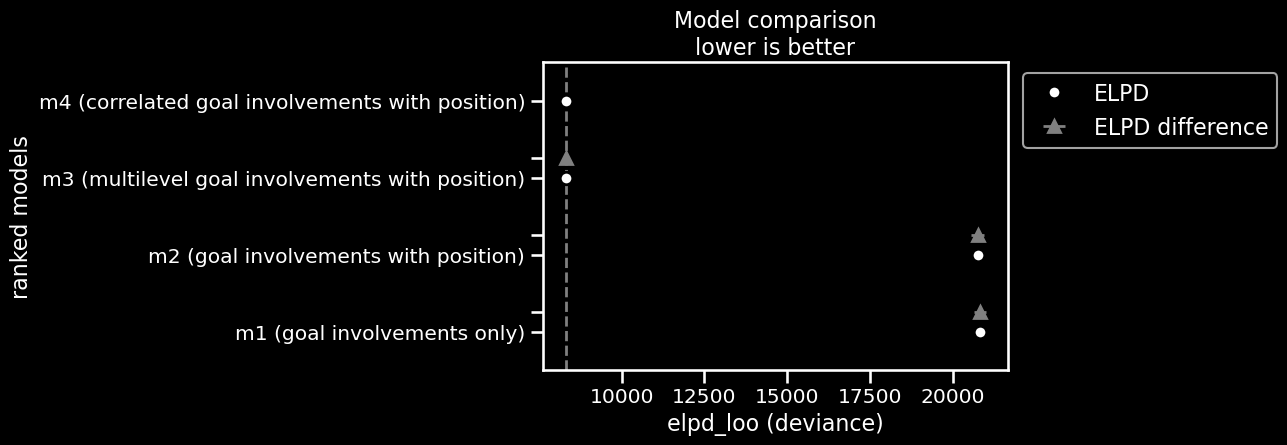

In [29]:
model_dict = {
    "m1 (goal involvements only)": idata_m1,
    "m2 (goal involvements with position)": idata_m2,
    "m3 (multilevel goal involvements with position)": idata_m3,
    "m4 (correlated goal involvements with position)": idata_m4
}
compare_df_psis = az.compare(
    compare_dict=model_dict,
    ic="loo",
    scale="deviance"
)
print(compare_df_psis)
_ = az.plot_compare(compare_df_psis)

## Effectiveness of Including Position Played
Including the player's position improves prediction accuracy by capturing positional differences in how goal involvements influence market value. Without accounting for position, the model might overestimate or underestimate market value for players in roles with differing expectations for scoring (e.g., defenders versus forwards). Like m4, which incorporates correlations between positions and goal involvements, enhance predictive power further by accounting for shared trends and variances between positions, making the inclusion of position highly effective.

## Insights  

The model comparison indicates differences in performance among the four models (m1, m2, m3, and m4), as measured by their ELPD values. Lower ELPD values indicate better model fit, and m4 (the correlations model) outperforms all others, closely followed by m3 (the hierarchical/multilevel model), m2 (stratified by position), and finally m1 (basic goal involvement model).  

**Addressing the Research Question:**  
The progression from m1 to m4 demonstrates a steady improvement in modeling market values by incorporating positional hierarchies and correlations, suggesting that position-specific relationships (as in m2, m3, and m4) better capture the variance in player market values, answering how positional roles and goal involvements impact market value.   

Defenders have a higher baseline value in this scenario since their value is primarily influenced by their defensive contributions and not offensive ones that we are considering here. Midfielders have a slightly lower baseline value and Forwards have the lowest baseline value. This can be explained by considering an example - A defender with 0 goal involvements is not necessarily a bad defender. They can be an exceptional defender that is not very strong in attacks, but, that still makes them more valuable than a midfielder with no goal contributions since being a part of the attack is a part of their job. A Forward with 0 goal contributions does not being much value to a team since Forwards are not involved in defense and their primary objective is to score or create goals, which is why they have the lowest baseline value.   

The slope is the highest for defenders, meaning that for the same number of goal involvements, defenders are more valuable than midfielders or forwards. This is quite expected since defenders that are involved in attacks despite also fulfilling their defensive duties are considered exceptional additions to a team. Therefore, if a forward and a defender have the same goal involvements, a defender is much more likely to have a higher valuation in the market thanks to their defensive attributes. Midfielders usually serve a dual purpose of both attacking and defending, which explains their slope being in between forwards and defenders.


**HDI Intervals for Defenders:**  
Across all models that considered position, the larger HDI intervals for defenders at higher goal contributions reflect higher uncertainty in their estimates at higher goal contributions. This is due to the smaller sample size of defenders with significant goal involvements. In the hierarchical models, partial pooling allows sharing of information across groups, but the sparsity of defender data still results in wider intervals compared to forwards and midfielders, who are better represented in the data.  

**Diagnostics of Posterior Models:**  
Across all models, the diagnostics indicate excellent performance: `r_hat` values of 1.0 suggest convergence of Markov chains with no mixing issues, and high `ess_bulk` values confirm that the effective sample size is sufficient for precise posterior estimates. This enhances our confidence in the conclusions drawn from the models.

**Model-Specific Insights:**  
* **m1 (Goal Involvement Model):** This model is the least effective, as it ignores positional context entirely, resulting in poor predictive performance (highest ELPD value).

* **m2 (Goal Involvements Stratified by Position):** While stratifying by position reduces some confounding effects, it treats each position independently, leading to overfitting for smaller groups like defenders.

* **m3 (Hierarchical/Multilevel Model):** The addition of hierarchical structure captures population-level trends and shares information across positions, reducing overfitting for smaller groups. This model performs substantially better than m1 and m2.

* **m4 (Correlations Model):** Incorporating correlations between position-specific intercepts and slopes further enhances the model’s capacity to capture relationships in the data. This explains its superior performance, as it balances population-level trends and individual group specifics effectively.

## Conclusion:  

The models highlight the importance of incorporating positional differences and correlations when modeling player market values. The hierarchical and correlations models (m3 and m4) not only reduce overfitting for underrepresented groups (like defenders) but also account for shared trends across positions. m4's superior performance underscores the value of modeling correlations, as it provides a more nuanced understanding of how goal involvements interact with position to influence market value. These findings address the research question comprehensively and are well-supported by the model diagnostics and ELPD results.  

A soccer player's goal involvements significantly influence their market value, with the effect varying based on the player's position. Defenders experience the largest increase in market value per unit of goal involvement, reflecting the value of their additional attacking capabilities alongside their defensive ones. Midfielders show a moderate impact, while forwards exhibit a weaker relationship between goal involvements and market value. This does not mean that goal involvements are not important for evaluating the value of forwards. It just means that for the same number of goals, a defender is expected to have a higher valuation than a forward, which makes sense since the defender is able to be involved in as many goals as the forward while also performing their primary duty of defending. The slopes can be misleading out of context since it is very rare to find defenders (mean goal involvements = 5) matching the goal involvements of forwards (mean goal involvements = 22).

## Future Improvements:

While the hierarchical and correlations models (m3 and m4) perform well and address the research question effectively, there is a lot of room for further improvement. By considering the impact of additional relevant factors, such as player age, league performance, injuries or contract length, we can enhance the predictive accuracy of the models. These factors very likely contribute to the market value of the players but are currently unaccounted for. Although team context was not explicitly accounted for in the analysis, the results suggest that incorporating it could further enhance the model by explaining additional variance in market values. For example, players from high-profile teams or leagues are likely to command higher market values irrespective of their individual goal involvements, due to team reputation and visibility. As such, while goal involvements remain a key determinant, the analysis highlights the importance of positional expectations and suggests potential gains from incorporating team-level effects in future models.

* **Dynamic Modeling:**
    Player market values are influenced by trends over time. Extending the analysis to include temporal dynamics (e.g., time-series modeling or varying effects by season) could provide insights into how positional roles and performance evolve.

* **Exploring Group-Level Interactions:**  
    Beyond position, interactions between other group-level variables (e.g., country of origin or playstyle) and individual predictors could add depth to the analysis.

* **Improved Uncertainty Quantification:**  
    The hierarchical models effectively share information, but future work could refine how group-specific uncertainties (e.g., for defenders) are modeled, potentially with more flexible covariance structures or shrinkage priors.